In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%pwd
%ls

data.py        gdrive/   maths.py      sample_data/
evaluation.py  iwvae.py  __pycache__/  utils.py


In [ ]:
import time, argparse, os
import traceback

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm
from torch.utils.data import DataLoader

from data import MirtDataset, create_factor_cov
from iwvae import MirtIWVAE, elbo, iw_elbo_dreg, check_valid_estimate
from data import MirtDataset, create_factor_cov
from evaluation import *
from maths import proj, sigmoid
from utils import makedirs, impute_observed_data


def evaluate(
    model, 
    data_loader, 
    just_projA, 
    loss, 
    silent=False
    ):
    
    with torch.no_grad():
        model.eval()
        y_pred = []
        y_true = []
        learn_x_mu = []
        for y_obs in data_loader:
            observed, y = impute_observed_data(y_obs)

            py_x, qx_y, x = model(y)
            y_recon = py_x.probs.mean((0, 1)).cpu().data.numpy()

            y_pred.append(1 * (y_recon >= 0.5))
            y_true.append(y_obs.cpu().data.numpy())

            learn_x_mu.append(qx_y.loc.cpu().data.numpy())

        y_pred = np.concatenate(y_pred, axis=0)
        y_true = np.concatenate(y_true, axis=0)
        learn_x_mu = np.concatenate(learn_x_mu, axis=0)

        pred_a = model.a.cpu().data.numpy()
        # the below are new added
        # for i in range(15):
        #   pred_a[i][1] *= 0
        #   pred_a[i][2] *= 0
        #   pred_a[i+15][0] *= 0
        #   pred_a[i+15][2] *= 0
        #   pred_a[i+30][0] *= 0
        #   pred_a[i+30][1] *= 0
        pred_b = model.b.cpu().data.numpy()
        pred_c = model.c.cpu().data.numpy()
        pred_d = model.d.cpu().data.numpy()

        pred_prob = pred_c + (pred_d - pred_c) * sigmoid(
            learn_x_mu @ pred_a.T + pred_b)

        real_a = data_loader.dataset.a.numpy()
        real_b = data_loader.dataset.b.numpy()
        real_c = data_loader.dataset.c.numpy()
        real_d = data_loader.dataset.d.numpy()
        real_x = data_loader.dataset.X.numpy()

        true_prob = real_c + (real_d - real_c) * sigmoid(
            real_x @ real_a.T + real_b)

        if loss == "bias":
            eval_fn = bias
        elif args.loss == "mae":
            eval_fn = mae
        elif args.loss == "mse":
            eval_fn = mse
        elif args.loss == "rmse":
            eval_fn = rmse
        else:
            raise ValueError(f"Invalid loss type: {loss}.")

        real_projA = proj(real_a)
        pred_projA = proj(pred_a)
        projA_diff = eval_fn(real_projA, pred_projA, axis=None)
        a_diff = a_loss(real_a, pred_a, eval_fn, axis=None,
                        method=args.rotate_method)
        b_diff = eval_fn(real_b, pred_b, axis=None)
        c_diff = eval_fn(real_c, pred_c, axis=None)
        d_diff = eval_fn(real_d, pred_d, axis=None)
        cd_diff = eval_fn(real_d - real_c, pred_d - pred_c, axis=None)
        prob_diff = eval_fn(true_prob, pred_prob, axis=None)
        accu = (1. * (y_pred == y_true)).mean()

    if not silent:
        print(f"accuracy: {(accu):.4f}, "
              f"prob_diff: {(prob_diff):.4f}, "
              f"projA_diff: {(projA_diff):.4f}, "
              f"a_diff: {(a_diff):.4f}, "
              f"b_diff: {(b_diff):.4f}, "
              f"c_diff: {(c_diff):.4f}, "
              f"d_diff: {(d_diff):.4f}, "
              f"cd_diff: {(cd_diff): .4f}")

    if just_projA:
        return accu, prob_diff, projA_diff, b_diff, c_diff, d_diff, cd_diff
    else:
        return accu, prob_diff, a_diff, projA_diff, b_diff, c_diff, d_diff, \
               cd_diff


def train_one_epoch(
        model,
        data_loader,
        optimizers,
        iters,
        tau = 20,
        #tau=1000,
        min_iter = 100,
        #min_iter=5000,
        previous_loss=np.inf,
        cur_loss=[],
        to_stop_times=0,
        to_stop_thre = 10,
        #to_stop_thre=50,
        stop=False,
        to_start_iw_thre=0,
        to_start_iw_times=0,
        use_iw=False,
        checkpoint = 20,
        #checkpoint=100,
        l1_penalty_list=[],
        l1_penalty_coef=0.,
        loss_hist=[]
    ):

    if l1_penalty_list:
        l1_loss = nn.L1Loss(reduction="mean")

    model.train()
    for y_obs in data_loader:
        y_observed, y = impute_observed_data(y_obs)

        track_loss = False if iters <= tau else True
        if iters == tau:
            cur_loss = []
            # We start to update c and d after the warm-up stage
            model.allow_update_decoder("c", "d")

        kl_weight = 1.
        if iters <= tau:
            kl_weight *= iters / tau

        if use_iw:
            py_x, qx_y, x = model(y, R=args.r, S=args.s)
            loss = -iw_elbo_dreg(y, y_observed, x, py_x, qx_y)
        else:
            py_x, qx_y, x = model(y, R=1, S=1)
            loss = -elbo(y, y_observed, x, py_x, qx_y, kl_weight)

        if l1_penalty_list:
            for param in l1_penalty_list:
                param_val = model.get_param(param)
                if param == "d":
                    prior_val = torch.ones_like(param_val)
                else:
                    prior_val = torch.zeros_like(param_val)
                loss += l1_penalty_coef * l1_loss(param_val, prior_val)
        loss.backward()
        if args.max_grad:
            clip_grad_norm(model.parameters(), clip_value=args.max_grad)

        for optimizer in optimizers:
            optimizer.step()
            optimizer.zero_grad()
        # clip_grad_value_(model.parameters(), clip_value=args.max_grad)
        # optimizer.step()

        if track_loss:
            if len(cur_loss) >= checkpoint:
                # Chek if stop decreasing
                cur_loss = np.array(cur_loss).mean()
                loss_hist.append(cur_loss)

                if previous_loss <= cur_loss:
                    # IW steps
                    if use_iw:
                        to_stop_times += 1
                    else:
                        to_start_iw_times += 1
                else:
                    # Only update `previous_loss` when improvement is achieved
                    previous_loss = cur_loss
                    # Reset stop improve count
                    if use_iw:
                        to_stop_times = 0
                    else:
                        to_start_iw_times = 0
                cur_loss = []
            else:
                cur_loss.append(loss.item())
        else:
            if len(cur_loss) >= checkpoint:
                loss_hist.append(np.array(cur_loss).mean())
                cur_loss = []
            else:
                cur_loss.append(loss.item())

        iters += 1

        if not use_iw:
            # Next iteration will start to use IW, reset `previous_loss`
            if to_start_iw_times >= to_start_iw_thre:
                use_iw = True
                previous_loss = np.infty
                print(f"Start to use IW-ELBO after {iters} iterations")

        if use_iw and to_stop_times >= to_stop_thre and iters > min_iter:
            # Converged under IW-ELBO: directly break the iteration and stop
            stop = True
            break

    return model, data_loader, optimizers, iters, \
           previous_loss, cur_loss, to_stop_times, to_stop_thre, stop, \
           to_start_iw_thre, to_start_iw_times, use_iw, loss_hist


In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Threestage IW-VAE on synthetic data")
    parser.add_argument("--replication-id", type=int, default=10)   # change from 1 to 10
    parser.add_argument("--trainnew", type=int, default=0)
    # data generation
    parser.add_argument("--asymptotic", type=str, default="single", choices=["single", "double"])
    parser.add_argument("--k", type=int, default=3)   # change this from 5 to 3
    parser.add_argument("--pl", type=int, default=3)  # represent the "MIRTx", could be 2, 3, or 4
    parser.add_argument("--a-shape", type=str, default="s")
    parser.add_argument("--correlated_factor", type=int, default=0)
    parser.add_argument("--factor-influ", type=int, default=15, help="Number of items each factor influences") # change 5 to 15
    parser.add_argument("--item-depend", type=int, default=1, help="Number of factors each item loads on") # change this from 2 to 1
    # Model architecture
    parser.add_argument("--depth", type=int, default=2)
    parser.add_argument("--restrict-a", type=str, default=None)
    parser.add_argument("--hidden-dim", type=int, default=128)
    parser.add_argument("--r", type=int, default=5)
    parser.add_argument("--s", type=int, default=1)
    parser.add_argument("--learn-sigma", type=int, default=1)
    # Train setting
    parser.add_argument("--batch-size", type=int, default=16)
    parser.add_argument("--max-iter", type=int, default=200_000)
    parser.add_argument("--stop-thre", type=int, default=50)
    parser.add_argument("--lr", type=float, default=0.01)
    parser.add_argument("--max-grad", type=float, default=None)
    parser.add_argument("--lasso", type=int, default=0)
    parser.add_argument("--l1-penalty-coef", type=float, default=0.0)
    # analysis setting
    parser.add_argument("--loss", type=str, default="rmse")
    parser.add_argument("--a-loss", type=str, default="proj")
    parser.add_argument("--rotate-method", type=str, default="promax")

    parser.add_argument('-f')    # must add this line for the next code to work
    args = parser.parse_args()

    args.l1_penalty_list = ["c", "d"] if args.lasso else None
    if args.l1_penalty_list:
        l1_loss = nn.L1Loss(reduction="mean")

    if args.restrict_a:
        restrict_a = {"none": None,
                      "exp": torch.exp,
                      "gelu": nn.GELU(),
                      "softplus": nn.Softplus()}
        args.restrict_a = restrict_a[args.restrict_a]

    to_save = "iwvae100rep"   # get the file in computer
    makedirs(to_save)
    
    # original data
    # ns = [500, 1000, 5000, 10000]
    # if args.asymptotic == "double":
    #     js = [100, 200, 300, 500]
    # else:
    #     js = [100, 100, 100, 100]
    
    # current data: reduce the size
    ns = [500]
    if args.asymptotic == "double":
        js = [25, 50, 100]
    else:
        js = [45, 45, 45]
    
    for n, j in zip(ns, js):
        args.max_observed = j // 5
        args.j = j

        print(
            f"Dataset: [n: {n}], "
            f"[J: {j}], "
            f"[K: {args.k}], "
            f"[pl: {args.pl}], "
            f"[a_shape: {args.a_shape}], "
            f"[factor_influ: {args.factor_influ}], "
            f"[item_depend: {args.item_depend}]."
            )

        factor_cor = "correlated" if args.correlated_factor else "diagonal"
        fpath = os.path.join(
                to_save,
                f"{factor_cor}#"
                f"{n}#"
                f"{j}#"
                f"{args.k}#"
                f"{args.pl}#"
                f"uniform#"
                f"{args.a_shape}#"
                f"{args.factor_influ}#"
                f"{args.item_depend}#"
                f"{args.max_observed}#"
                f"FALSE"
                f"_rep{args.replication_id}"
                ".torch")
        
        if args.trainnew is False and os.path.isfile(fpath):
            print(f"Find trained file: {fpath}")
            break
            
        else:
            factor_cov_mat = create_factor_cov(
                args.correlated_factor,
                args.k)
                
            data = MirtDataset(
                n,
                j,
                args.k,
                args.pl,
                link=sigmoid,
                with_b=True,
                Lambda_dist="uniform",
                factor_cov_mat=factor_cov_mat,
                a_shape=args.a_shape,
                factor_influ=args.factor_influ,
                item_depend=args.item_depend,
                max_observed=args.max_observed,
                seed=18 ##### change here to get different a, b, and c
                )
            
            data_loader = DataLoader(data, batch_size=args.batch_size)

            real_a = data.a.numpy()
            real_b = data.b.numpy()
            real_c = data.c.numpy()
            real_d = data.d.numpy()
            
            show_each_eval = False
            epoch = args.max_iter // (n // args.batch_size)
            if args.hidden_dim is None:
                args.hidden_dim = (j + args.k) // 2

            start = time.time()
            try:
                model = MirtIWVAE(
                    input_size=args.j,
                    hidden_size=args.hidden_dim,
                    depth=args.depth,
                    latent_size=args.k,
                    pl=args.pl,
                    restrict_a=args.restrict_a,
                    activation_fn=nn.Tanh(),
                    seed=args.replication_id,
                    )
                # Only train A and b at the begining of model fitting. 
                model.allow_update_decoder("a", "b")
                # model.allow_update_decoder("b")
                # Train c and d with smaller learning rates.
                fast_params, slow_params = [], []
                for name, param in model.named_parameters():
                    if name in ["unrestrict_c", "unrestrict_d"]:
                        slow_params.append(param)
                    else:
                        fast_params.append(param)

                optimizers = []
                if slow_params:
                    optimizers.append(
                        torch.optim.SGD(slow_params, args.lr / 10)
                        )
                if fast_params:
                    optimizers.append(
                        torch.optim.SGD(fast_params, args.lr)
                        )

                # stats
                iters = 0
                previous_loss = np.inf
                cur_loss = []
                loss_hist =[]

                to_stop_times = 0
                to_start_iw_times = 0
                use_iw = False
                stop = False

                to_start_iw_thre = args.stop_thre
                to_stop_thre = args.stop_thre

                for e in range(1, epoch + 1):
                    if stop:
                        print(f"Finish trail: "
                            f"[early stop: {iters}] in "
                            f"{(time.time() - start):.2f} sec...")

                        break
                    else:
                        model, data_loader, optimizers, iters, \
                        previous_loss, cur_loss, to_stop_times, to_stop_thre, stop, \
                        to_start_iw_thre, to_start_iw_times, use_iw, loss_hist = train_one_epoch(
                            model, data_loader, optimizers, iters,
                            tau=(args.max_iter // 100),
                            min_iter=(args.max_iter // 10),
                            previous_loss=previous_loss,
                            cur_loss=cur_loss,
                            to_stop_times=to_stop_times,
                            to_stop_thre=to_stop_thre,
                            to_start_iw_times=to_start_iw_times,
                            to_start_iw_thre=to_start_iw_thre,
                            use_iw=use_iw,
                            stop=stop,
                            l1_penalty_list=args.l1_penalty_list,
                            l1_penalty_coef=args.l1_penalty_coef,
                            loss_hist=loss_hist
                            )
                        check_valid_estimate(model)

                if e == epoch:
                    print(f"Finish trial: "
                        f"[reach max iterations: {iters}] in "
                        f"{(time.time() - start):.2f} sec...")

                fit_time = time.time() - start
                torch.save(model.state_dict(), fpath)
                pd.DataFrame(np.array([fit_time])).to_csv(fpath.replace(".torch", "_time.csv"), index=None)
                print("-" * 120)

                a = model.a.cpu().data.numpy()
                b = model.b.cpu().data.numpy()
                c = model.c.cpu().data.numpy()
                # other 0
                for i in range(15):
                  a[i][1] *= 0.
                  a[i][2] *= 0.
                  a[i+15][0] *= 0.
                  a[i+15][2] *= 0.
                  a[i+30][0] *= 0.
                  a[i+30][1] *= 0.
                print(a)
                # print(b)
                # print(c)
                list_a.append(a)
                list_b.append(b)
                list_c.append(c)
                # pd.DataFrame(a).to_csv("a.csv")


            except Exception as e:
                print(f"Fail on trial = {args.replication_id}...")
                traceback.print_exc()

Dataset: [n: 500], [J: 45], [K: 3], [pl: 3], [a_shape: s], [factor_influ: 15], [item_depend: 1].
Start to use IW-ELBO after 7964 iterations
Finish trail: [early stop: 20732] in 72.69 sec...
------------------------------------------------------------------------------------------------------------------------
[[-0.02052886  0.          0.        ]
 [ 0.56683934  0.          0.        ]
 [ 0.41758287  0.          0.        ]
 [ 0.1891375   0.          0.        ]
 [ 0.4773882   0.          0.        ]
 [ 0.3860041   0.          0.        ]
 [ 0.49017262  0.          0.        ]
 [ 0.2738048   0.          0.        ]
 [ 0.47587612  0.          0.        ]
 [ 0.10159583  0.         -0.        ]
 [ 0.0436631   0.         -0.        ]
 [ 0.09781677  0.         -0.        ]
 [ 0.16475363  0.         -0.        ]
 [ 0.0614897   0.         -0.        ]
 [ 0.15905869  0.         -0.        ]
 [ 0.         -0.05758711  0.        ]
 [ 0.         -0.01621555  0.        ]
 [-0.         -0.04833857 

In [ ]:
from ctypes import LittleEndianStructure
# only run this section once!
# list_a = []
# list_b = []
# list_c = []
list_a
# list_b
# list_c

In [ ]:
# error analysis

# helper functions
def matrix_sum(a_row, a_col, m1, m2):
  s = 0
  for i in range(a_row):
    for j in range(a_col):
      s = s + m1[i][j] - m2[i][j]
  return s

def matrix_abs_sum(a_row, a_col, m1, m2):
  s = 0
  for i in range(a_row):
    for j in range(a_col):
      s = s + abs(m1[i][j] - m2[i][j])
  return s

def matrix_square_sum(a_row, a_col, m1, m2):
  s = 0
  for i in range(a_row):
    for j in range(a_col):
      s = s + pow((m1[i][j] - m2[i][j]), 2)
  return s

def array_square_sum(b_len, m1, m2):
  s = 0
  for i in range(45):
    s = s + pow((m1[i] - m2[i]), 2)
  return s

# first task: calculate bias
# formula: add difference of each entry and take average
def calc_bias_a():
  s = 0
  for i in range(10):
    s += matrix_sum(45, 3, list_a[i], real_a)
  s = s / 10
  return s

# second task: calculate L1 error
# formula: add absolute difference of each entry and take average
def calc_l1_a():
  s = 0
  for i in range(10):
    s += matrix_abs_sum(45, 3, list_a[i], real_a)
  s = s / 10
  return s

# third task: calculate root mean squared error
# formula: square root of L2 error then divided by n
def calc_rmse_a():
  s = 0
  for i in range(10):
    s += matrix_square_sum(45, 3, list_a[i], real_a)
  s = s / 10
  s = pow(s, 0.5)
  return s

def calc_rmse_b():
  s = 0
  for i in range(10):
    s = s + array_square_sum(45, list_b[i], real_b)
  s = s / 10
  s = pow(s, 0.5)
  return s

print(calc_rmse_a())
print(calc_rmse_b())

6.464265215568251
8.434744543288868


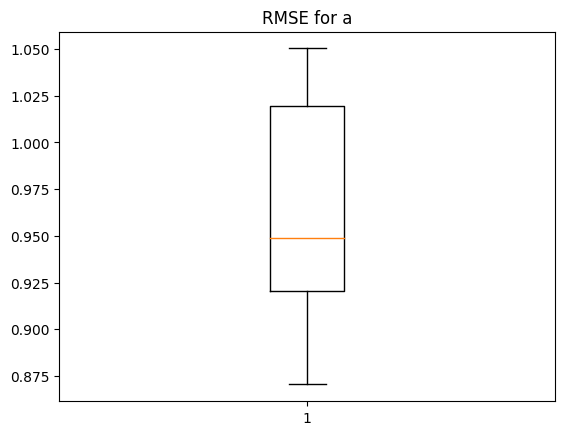

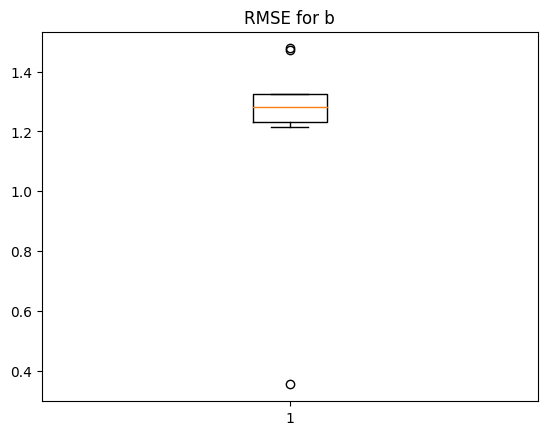

In [ ]:
# obtain box plot for RMSE
# this is the M2PL result

# helper functions
def rmse_a(a_row, a_col, m1, m2):
  s = 0
  for i in range(a_row):
    for j in range(a_col):
      s = s + pow((m1[i][j] - m2[i][j]), 2)
  s = s / 45
  s = pow(s, 0.5)
  return s

def rmse_b(b_len, m1, m2):
  s = 0
  for i in range(b_len):
    s = s + pow((m1[i] - m2[i]), 2)
  s = s / 45
  s = pow(s, 0.5)
  return s

# calculate RMSE
def plot_rmse_a():
  list_rmse_a = []
  for i in range(10):
    list_rmse_a.append(rmse_a(45, 3, list_a[i], real_a))
  # l = [list_rmse_a, list_rmse_b]
  
  # fig = plt.figure(figsize =(10, 7))
  # ax = fig.add_axes([0, 0, 1, 1])
  # bp = ax.boxplot(l)
  plt.boxplot(list_rmse_a)
  plt.title("RMSE for a")
  plt.show()

def plot_rmse_b():
  list_rmse_b = []
  for i in range(10):
    list_rmse_b.append(rmse_b(45, list_b[i], real_b))
  plt.boxplot(list_rmse_b)
  plt.title("RMSE for b")
  plt.show()

plot_rmse_a()
plot_rmse_b()

6.464265215568251
8.434744543288868
0.587634514422825


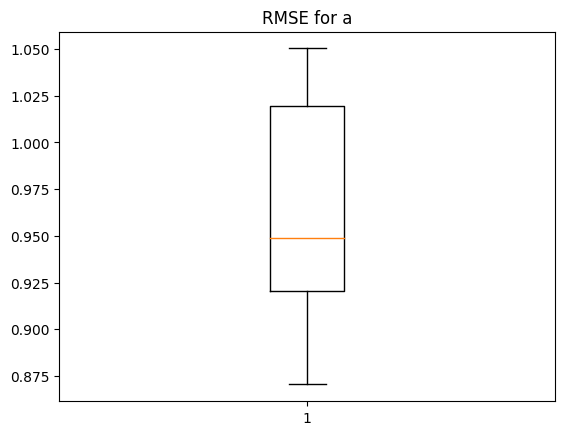

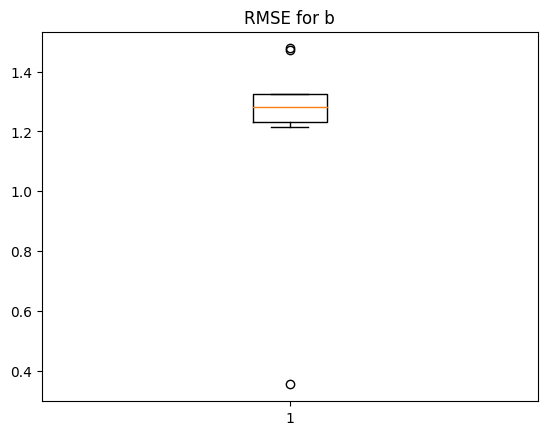

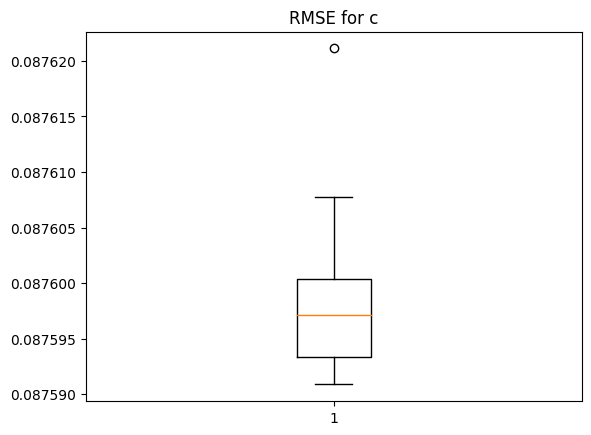

In [ ]:
# obtain box plot for RMSE
# this is M3PL result

# helper function
def rmse_a(a_row, a_col, m1, m2):
  s = 0
  for i in range(a_row):
    for j in range(a_col):
      s = s + pow((m1[i][j] - m2[i][j]), 2)
  s = s / 45   # should it be 45 here or 135? ie. should we consider all the positions or just the non-zero positions?
  s = pow(s, 0.5)
  return s

def rmse_b(b_len, m1, m2):
  s = 0
  for i in range(b_len):
    s = s + pow((m1[i] - m2[i]), 2)
  s = s / 45
  s = pow(s, 0.5)
  return s

# calculate RMSE
def plot_rmse_a():
  list_rmse_a = []
  for i in range(10):
    list_rmse_a.append(rmse_a(45, 3, list_a[i], real_a))
  # l = [list_rmse_a, list_rmse_b]
  
  # fig = plt.figure(figsize =(10, 7))
  # ax = fig.add_axes([0, 0, 1, 1])
  # bp = ax.boxplot(l)
  plt.boxplot(list_rmse_a)
  plt.title("RMSE for a")
  plt.show()
  # return list_rmse_a

def plot_rmse_b():
  list_rmse_b = []
  for i in range(10):
    list_rmse_b.append(rmse_b(45, list_b[i], real_b))
  plt.boxplot(list_rmse_b)
  plt.title("RMSE for b")
  plt.show()
  # return list_rmse_b
  
def calc_rmse_c():
  s = 0
  for i in range(10):
    s = s + array_square_sum(45, list_c[i], real_c)
  s = s / 10
  s = pow(s, 0.5)
  return s

def rmse_c(c_len, m1, m2):
  s = 0
  for i in range(c_len):
    s = s + pow((m1[i] - m2[i]), 2)
  s = s / 45
  s = pow(s, 0.5)
  return s

def plot_rmse_c():
  list_rmse_c = []
  for i in range(10):
    list_rmse_c.append(rmse_c(45, list_c[i], real_c))
  plt.boxplot(list_rmse_c)
  plt.title("RMSE for c")
  plt.show()
  # return list_rmse_c

print(calc_rmse_a())
print(calc_rmse_b())
print(calc_rmse_c())

plot_rmse_a()
plot_rmse_b()
plot_rmse_c()


# fig, ax = plt.subplots()
# d1 = plot_rmse_a()
# d2 = plot_rmse_b()
# d3 = plot_rmse_c()
# ax.boxplot([d1, d2, d3])
# # ax.boxplot([d1, d2])
# ax.set_xticklabels(['Data 1', 'Data 2', 'Data 3'])
# # ax.set_xticklabels(['Data 1', 'Data 2'])
# ax.set_ylabel('Value')
# ax.set_title('Three Boxplots Side by Side')

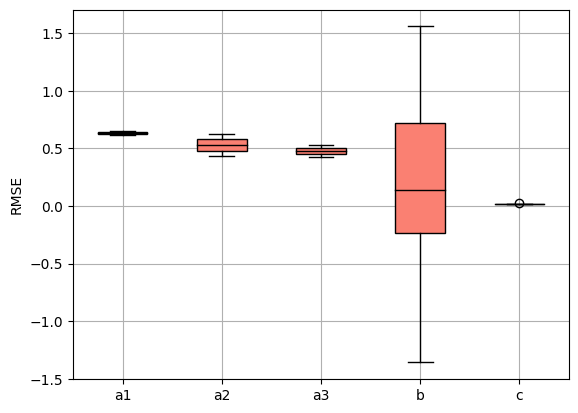

In [ ]:
# RMSE, M3PL, IWVAE, replicaiton 10, sample size 500
def a_i(col, m1, m2):
  s = 0
  for j in range(45):
    s = s + pow(abs(m1[j][col] - m2[j][col]), 2)
  s = s / 45
  s = pow(s, 0.5)
  return s

def plot_a():
  l = []
  s = []
  k = []
  for i in range(2):
    l.append(a_i(0, list_a[i], real_a))
    s.append(a_i(1, list_a[i], real_a))
    k.append(a_i(2, list_a[i], real_a))

  fig, ax = plt.subplots()
  boxprops = dict(facecolor='salmon', edgecolor='black')
  medianprops = dict(linestyle='-', linewidth=1, color='black')
  ax.boxplot([l, s, k, b, c], patch_artist=True, boxprops=boxprops, medianprops=medianprops)
  ax.set_xticklabels(['a1', 'a2', 'a3', 'b', 'c'])
  for median in ax.lines[4:9]:
    median.set_color('black')
  ax.set_ylabel('RMSE')
  ax.set_facecolor('white')
  plt.grid()
  plt.show()

plot_a()